# Laboratorio 4 Parte 2- Análisis de modelos usando datos geospaciales

### Sebastián Juárez - 21471
### Juan Pablo Cordón - 21458
Link al github: https://github.com/SebasJuarez/DS-Collection/tree/Lab4

In [14]:
import pandas as pd
import numpy as np

atitlan = pd.read_csv("atitlan_indices_todas_las_fechas.csv")

atitlan["date"] = pd.to_datetime(atitlan["date"], format="%Y-%m-%d")

atitlan.head()

,date,coverage_pct,coverage_pct_poly,coverage_pct_water,chl_mean,chl_median,chl_p95,ndvi_mean,ndwi_mean,valid_px,water_px
0,2025-02-07,0.205518,0.205518,0.999811,-1.318510e+10,4.746356,1204.932007,0.904062,9.587302,981862,982048
1,2025-02-10,0.000263,0.000263,1.000000,4.040736e+00,4.260046,4.732763,-0.135770,0.436340,1258,1258
2,2025-02-25,0.049464,0.049464,1.000000,5.287579e-01,3.963018,4.691946,0.308929,0.595625,236316,236316
3,2025-02-27,0.268881,0.268881,0.999948,3.224710e+00,3.596182,4.517667,-0.143003,0.403314,1284579,1284646
4,2025-03-02,0.028497,0.028497,1.000000,-2.103549e+09,3.172209,10.806772,0.289753,0.760607,136144,136144


## Series de tiempo

### Serie de tiempo Lago de Atitlan

In [17]:
# Crear serie temporal de chl_p95
chl_p95 = atitlan["chl_p95"]
chl_p95.index = atitlan["date"]
chl_median = atitlan["chl_median"]
chl_median.index = atitlan["date"]

chl_p95 

date
2025-02-07    1204.932007
2025-02-10       4.732763
2025-02-25       4.691946
2025-02-27       4.517667
2025-03-02      10.806772
2025-03-04       4.512647
2025-03-07     675.900330
2025-03-09       4.435485
2025-03-12       4.896786
2025-03-14       4.448634
2025-03-19       4.597617
2025-03-22    4779.981787
2025-03-24       4.604187
2025-03-26       5.286236
Name: chl_p95, dtype: float64

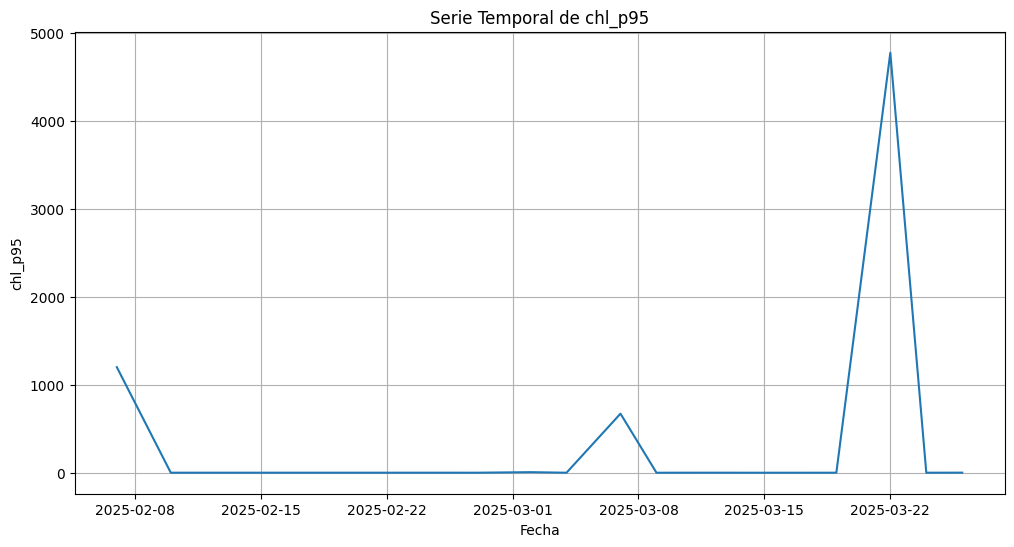

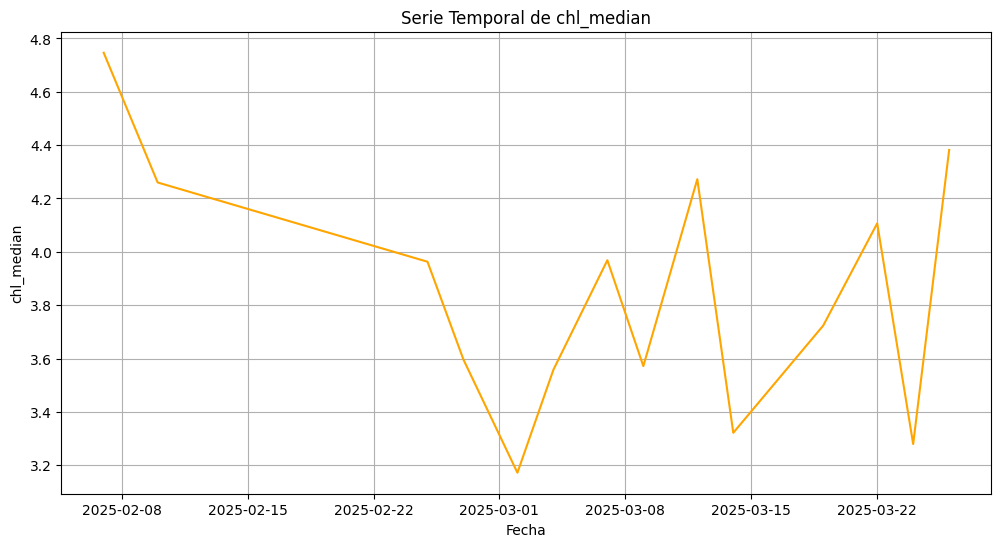

In [19]:
# Grafica serie temporal chl_p95
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(chl_p95.index, chl_p95.values)
plt.title("Serie Temporal de chl_p95")
plt.xlabel("Fecha")
plt.ylabel("chl_p95")
plt.grid(True)
plt.show()

# Graficar chl_median
plt.figure(figsize=(12, 6))
plt.plot(chl_median.index, chl_median.values, color='orange')
plt.title("Serie Temporal de chl_median")
plt.xlabel("Fecha")
plt.ylabel("chl_median")
plt.grid(True)
plt.show()

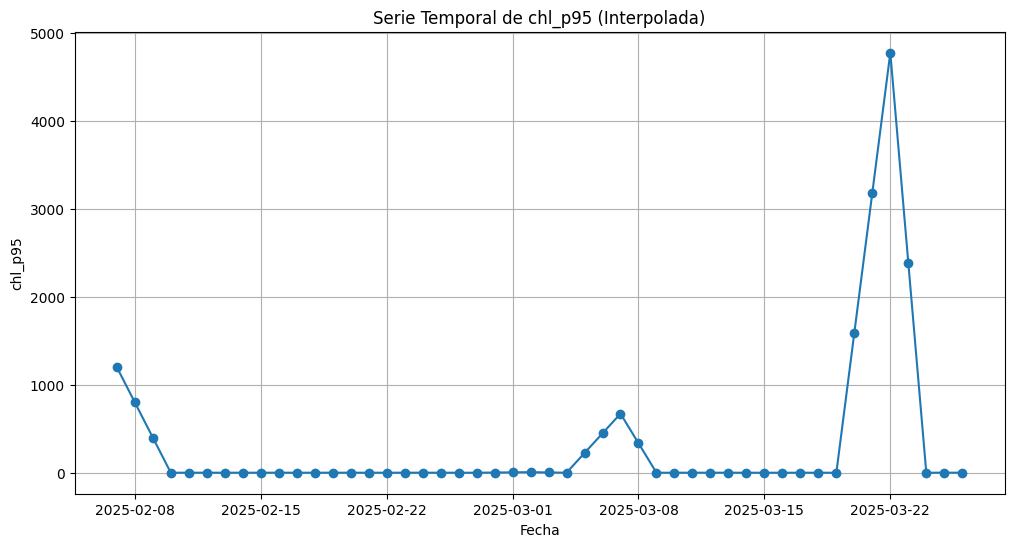

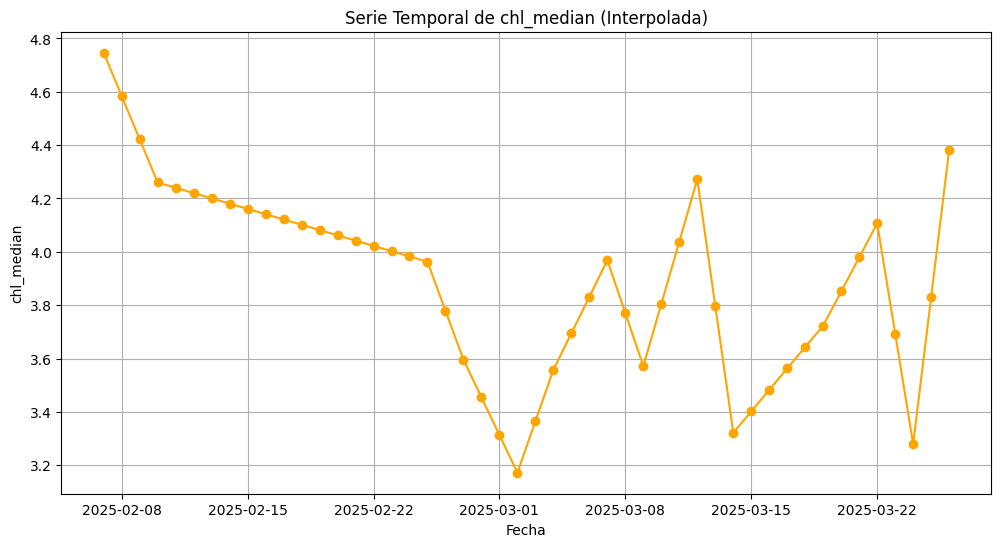

In [24]:
# Interpolar datos para suavizar
chl_p95 = chl_p95.resample("D").interpolate()
chl_median = chl_median.resample("D").interpolate()

# Graficar con datos interpolados
plt.figure(figsize=(12, 6))
plt.plot(chl_p95.index, chl_p95.values, marker='o')
plt.title("Serie Temporal de chl_p95 (Interpolada)")
plt.xlabel("Fecha")
plt.ylabel("chl_p95")
plt.grid(True)
plt.show()

# Graficar chl_median
plt.figure(figsize=(12, 6))
plt.plot(chl_median.index, chl_median.values, color='orange', marker='o')
plt.title("Serie Temporal de chl_median (Interpolada)")
plt.xlabel("Fecha")
plt.ylabel("chl_median")
plt.grid(True)
plt.show()

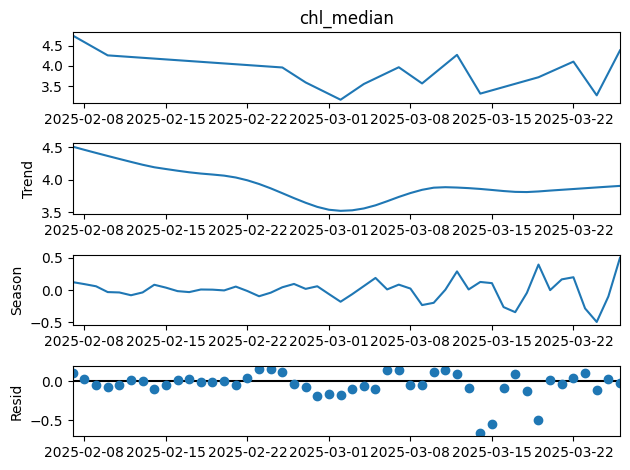

In [29]:
from statsmodels.tsa.seasonal import STL

res = STL(chl_median.dropna(), period=7, robust=True).fit()
res.plot()
plt.show()

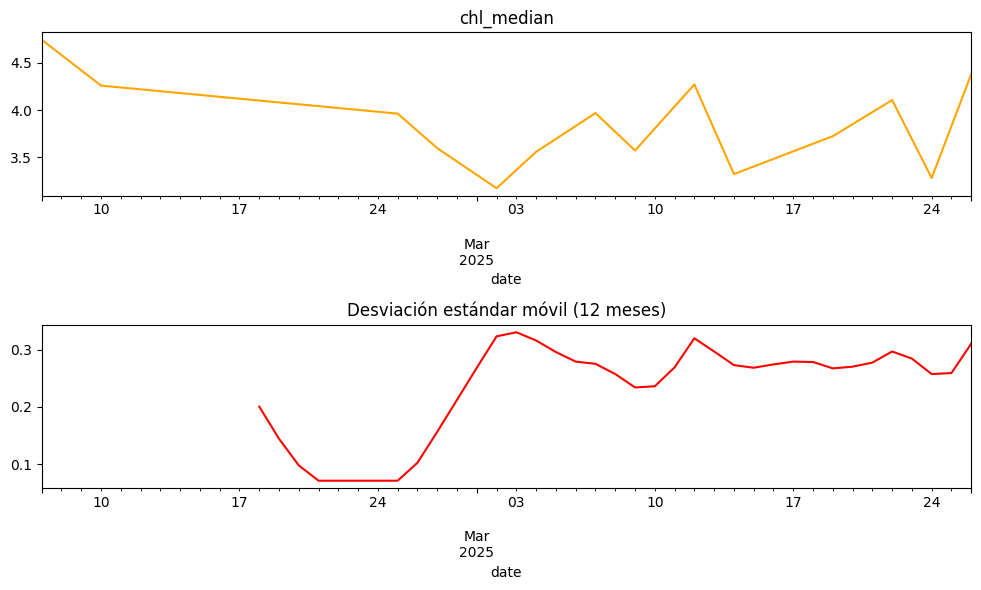

In [31]:
desvMovil = chl_median.rolling(window=12).std()

fig, ax = plt.subplots(2, 1, figsize=(10,6))
chl_median.plot(ax=ax[0], color="orange", title="chl_median")
desvMovil.plot(ax=ax[1], color="red", title="Desviación estándar móvil (12 meses)")
plt.tight_layout()
plt.show()

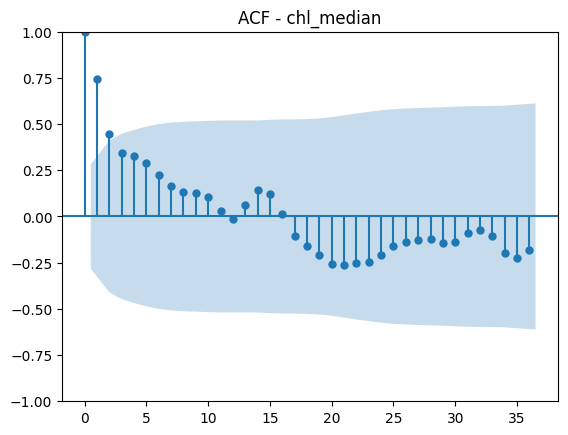

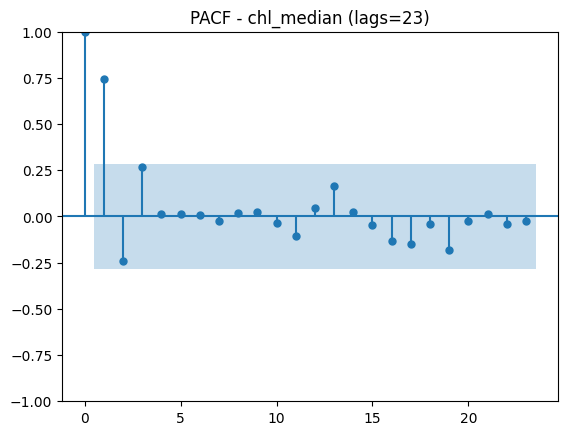

ADF: estadístico=-2.485, p-valor=0.119


In [33]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# ACF y PACF
plot_acf(chl_median.dropna(), lags=36)
plt.title("ACF - chl_median")
plt.show()

# Calcular lags máximo permitido para PACF
max_lags = int(len(chl_median.dropna()) // 2) - 1
plot_pacf(chl_median.dropna(), lags=max_lags, method="ywm")
plt.title(f"PACF - chl_median (lags={max_lags})")
plt.show()

# Prueba ADF
stat, pval, lags, nobs, _, _ = adfuller(chl_median.dropna(), autolag="AIC")
print(f"ADF: estadístico={stat:.3f}, p-valor={pval:.3f}")


                               SARIMAX Results                                
Dep. Variable:             chl_median   No. Observations:                   48
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  18.619
Date:                Thu, 14 Aug 2025   AIC                            -29.237
Time:                        16:27:09   BIC                            -21.752
Sample:                    02-07-2025   HQIC                           -26.409
                         - 03-26-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.9746      0.137     28.990      0.000       3.706       4.243
ar.L1          0.7103      0.106      6.700      0.000       0.503       0.918
ma.L1          0.8534      0.090      9.476      0.0

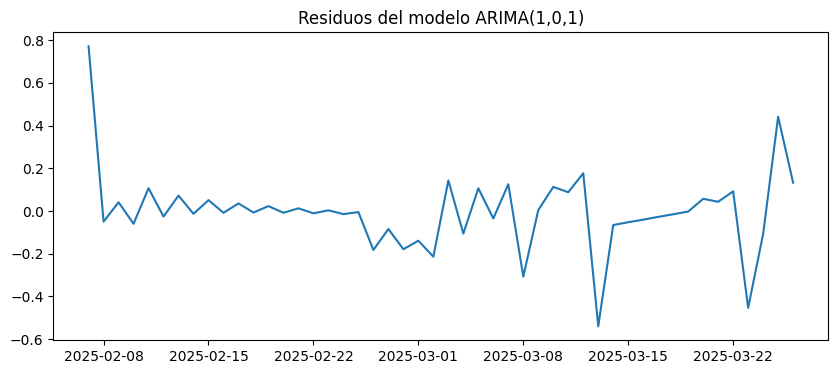

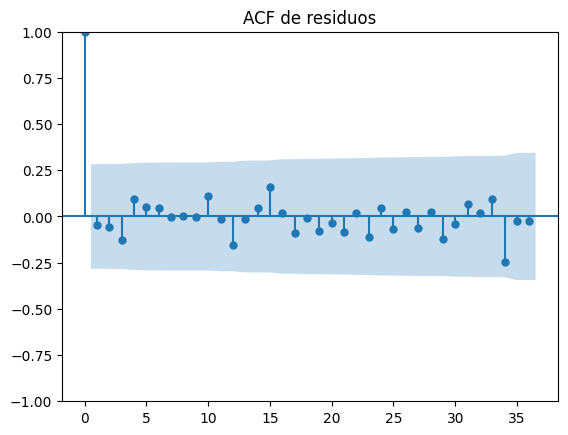

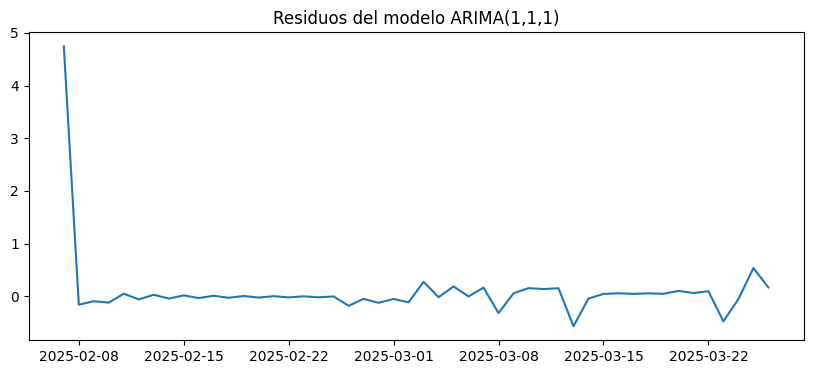

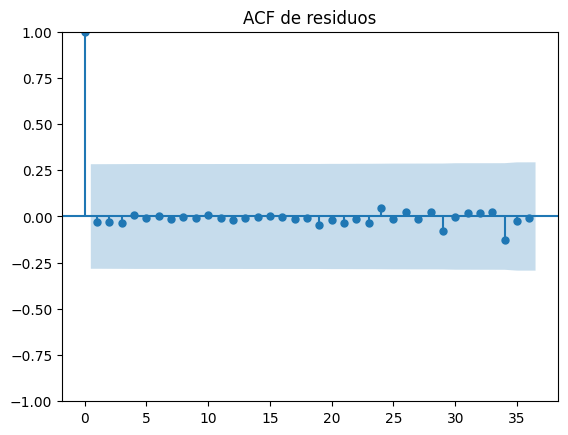

In [37]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Ajustar modelo ARIMA (p=1, d=0, q=1)
modelo = ARIMA(chl_median.dropna(), order=(1,0,1))
resultado = modelo.fit()

print(resultado.summary())  # Ver AIC/BIC y parámetros

# Graficar residuos
residuos = resultado.resid
plt.figure(figsize=(10,4))
plt.plot(residuos)
plt.title('Residuos del modelo ARIMA(1,0,1)')
plt.show()

# ACF de residuos
sm.graphics.tsa.plot_acf(residuos, lags=36)
plt.title('ACF de residuos')
plt.show()

modelo2 = ARIMA(chl_median.dropna(), order=(1,1,1))
resultado2 = modelo2.fit()

# Graficar residuos
residuos2 = resultado2.resid
plt.figure(figsize=(10,4))
plt.plot(residuos2)
plt.title('Residuos del modelo ARIMA(1,1,1)')
plt.show()

# ACF de residuos
sm.graphics.tsa.plot_acf(residuos2, lags=36)
plt.title('ACF de residuos')
plt.show()


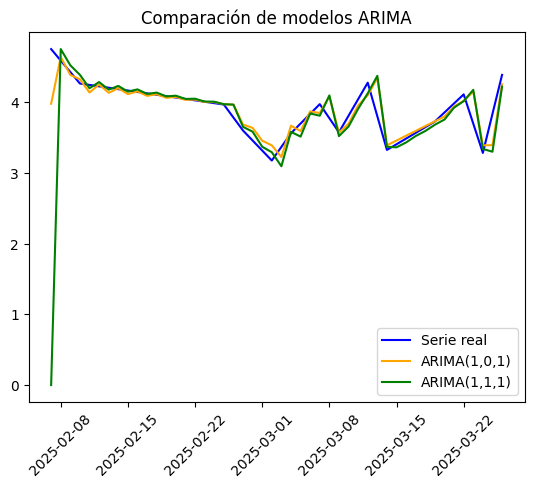

In [39]:
# Grafica ambos modelos sobre la serie real
plt.plot(chl_median.dropna(), label='Serie real', color='blue')
plt.plot(resultado.fittedvalues, label='ARIMA(1,0,1)', color='orange')
plt.plot(resultado2.fittedvalues, label='ARIMA(1,1,1)', color='green')
plt.legend()
plt.xticks(rotation=45)
plt.title('Comparación de modelos ARIMA')
plt.show()

In [41]:
# Verifica el mejor modelo con autoarima
from pmdarima import auto_arima

modelo_auto = auto_arima(chl_median.dropna(),
     seasonal=True, 
     stepwise=True,
     trace=True)
print(modelo_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-27.139, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9.510, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.234, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-26.137, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.445, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13.234, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-26.137, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11.445, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-27.522, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-25.911, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-24.902, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-27.522, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-25.911, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-24.902, Time=0.05 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-26.46

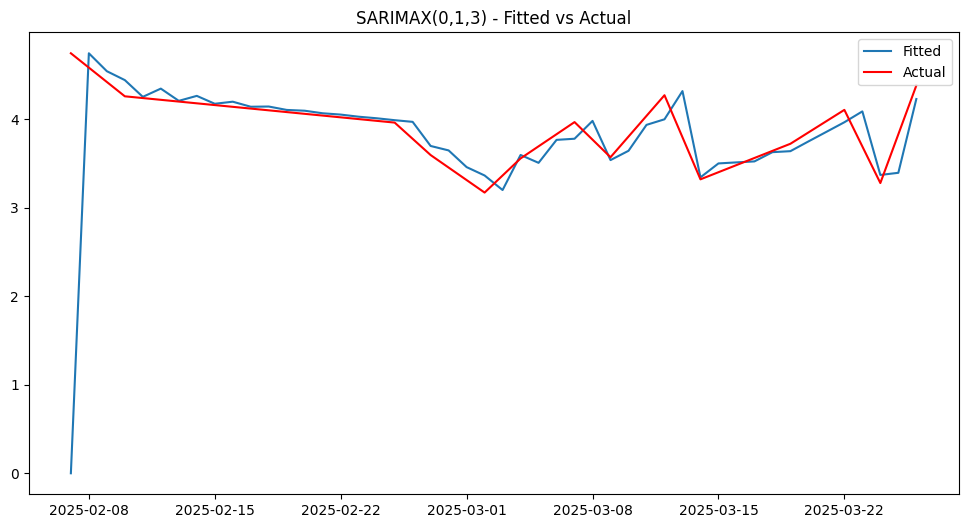

In [47]:
# El mejor modelo fue SARIMAX(0,1,3) sin estacionalidad. Realiza el modelo y grafica.

from statsmodels.tsa.statespace.sarimax import SARIMAX

best_model = SARIMAX(chl_median.dropna(), order=(0, 1, 3), seasonal_order=(0, 0, 0, 0))
results = best_model.fit()
plt.show()

# Graficar serie contra valores del modelo
plt.figure(figsize=(12, 6))
plt.plot(results.fittedvalues)
plt.plot(chl_median.dropna(), color='red')
plt.title('SARIMAX(0,1,3) - Fitted vs Actual')
plt.legend(['Fitted', 'Actual'])
plt.show()

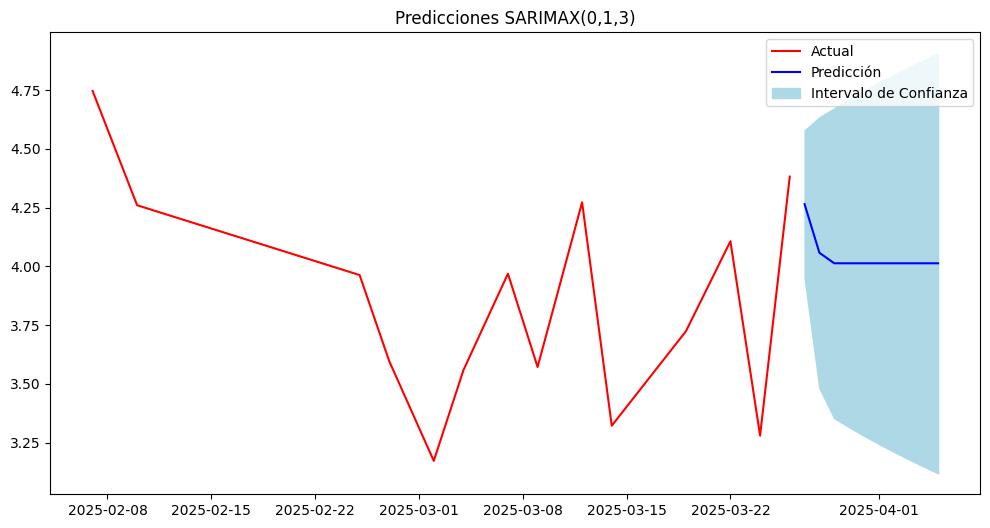

In [48]:
# Predicciones
pred = results.get_forecast(steps=10)
pred_conf = pred.conf_int()

# Graficar predicciones
plt.figure(figsize=(12, 6))
plt.plot(chl_median.dropna(), color='red')
plt.plot(pred.predicted_mean, color='blue')
plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='lightblue')
plt.title('Predicciones SARIMAX(0,1,3)')
plt.legend(['Actual', 'Predicción', 'Intervalo de Confianza'])
plt.show()

### Serie de tiempo Lago de Amatitlan

In [54]:
df = pd.read_csv("serie_inicio_fin_mes.csv")
amatitlan = df[df['lake'] == 'Amatitlan']
amatitlan["date"] = pd.to_datetime(amatitlan["date"], format="%Y-%m-%d")

amatitlan.head()

C:\Users\jpcor\AppData\Local\Temp\ipykernel_19088\1294889512.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amatitlan["date"] = pd.to_datetime(amatitlan["date"], format="%Y-%m-%d")


,lake,date,water_px,valid_px,coverage_pct_water,chl_mean,chl_median,chl_p95,ndvi_mean,ndwi_mean,tif_path,error
0,Amatitlan,2025-02-07,39401.0,39401.0,1.0,26.963100,20.768581,63.828270,-1.518291,2.041242,tiffs_mes\Amatitlan\Amatitlan_2025-02-07.tif,NaN
1,Amatitlan,2025-02-27,53187.0,53187.0,1.0,15.771939,6.095391,51.166000,0.007404,0.155648,tiffs_mes\Amatitlan\Amatitlan_2025-02-27.tif,NaN
2,Amatitlan,2025-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[400] NoDataAvailable: There is no data availa...
3,Amatitlan,2025-03-26,37480.0,37480.0,1.0,8.456269,7.469249,15.018612,0.009998,0.163318,tiffs_mes\Amatitlan\Amatitlan_2025-03-26.tif,NaN
4,Amatitlan,2025-04-03,50712.0,50712.0,1.0,9.667562,5.114092,37.105206,-0.106983,0.255355,tiffs_mes\Amatitlan\Amatitlan_2025-04-03.tif,NaN


In [68]:
# Reset index to ensure alignment
amatitlan_reset = amatitlan.reset_index(drop=True)
chl_median_amatitlan = amatitlan_reset.loc[
    amatitlan_reset["chl_median"].notna(), ["date", "chl_median"]
].set_index("date")["chl_median"]

chl_p95_amatitlan = amatitlan_reset.loc[
    amatitlan_reset["chl_p95"].notna(), ["date", "chl_p95"]
].set_index("date")["chl_p95"]

chl_p95_amatitlan

date
2025-02-07    63.828270
2025-02-27    51.166000
2025-03-26    15.018612
2025-04-03    37.105206
2025-04-28    37.821477
2025-05-03    17.123645
2025-05-28    10.376954
Name: chl_p95, dtype: float64

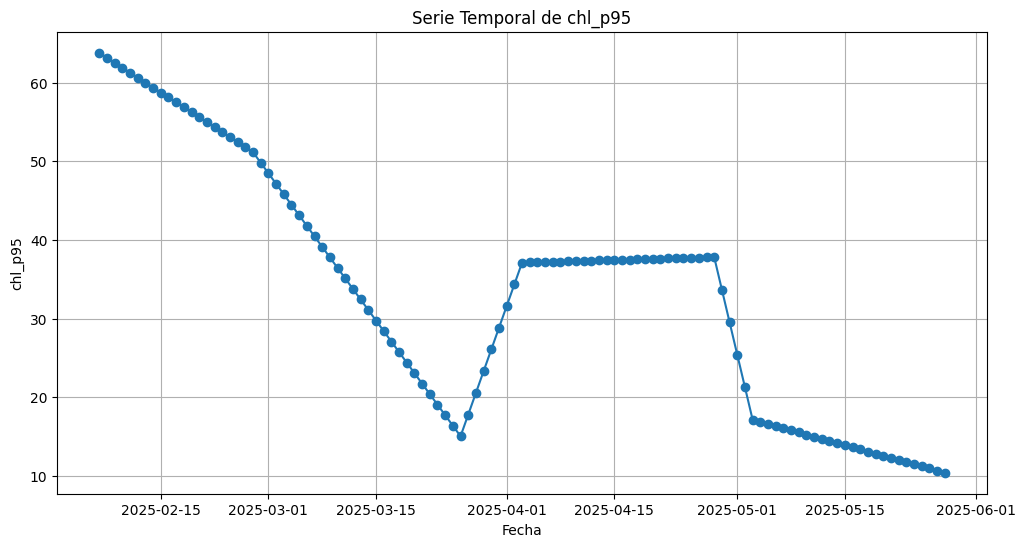

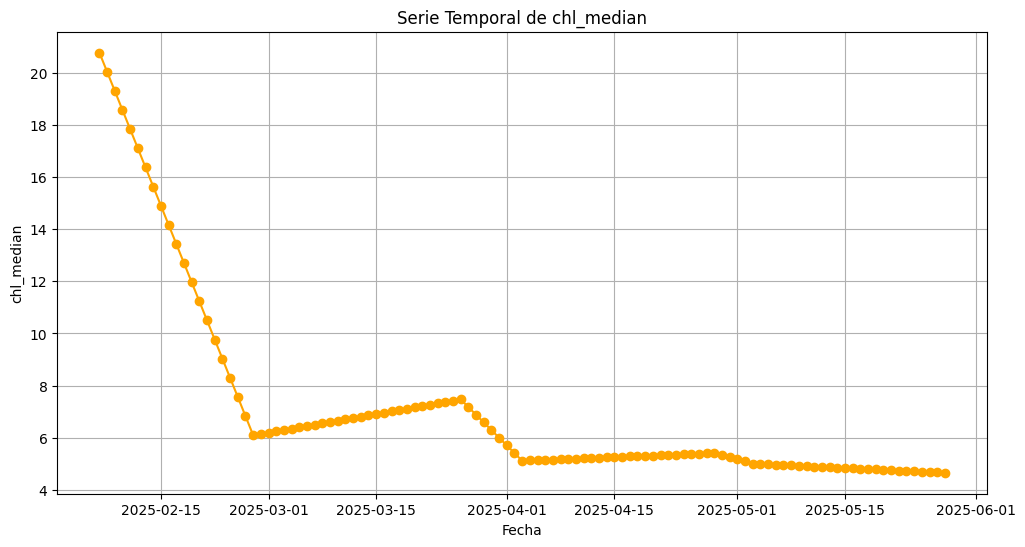

In [71]:
# Interpolar datos para suavizar
chl_p95_amatitlan = chl_p95_amatitlan.resample("D").interpolate()
chl_median_amatitlan = chl_median_amatitlan.resample("D").interpolate()

# Grafica serie temporal chl_p95
plt.figure(figsize=(12, 6))
plt.plot(chl_p95_amatitlan.index, chl_p95_amatitlan.values, marker='o')
plt.title("Serie Temporal de chl_p95")
plt.xlabel("Fecha")
plt.ylabel("chl_p95")
plt.grid(True)
plt.show()

# Graficar chl_median
plt.figure(figsize=(12, 6))
plt.plot(chl_median_amatitlan.index, chl_median_amatitlan.values, color='orange', marker='o')
plt.title("Serie Temporal de chl_median")
plt.xlabel("Fecha")
plt.ylabel("chl_median")
plt.grid(True)
plt.show()

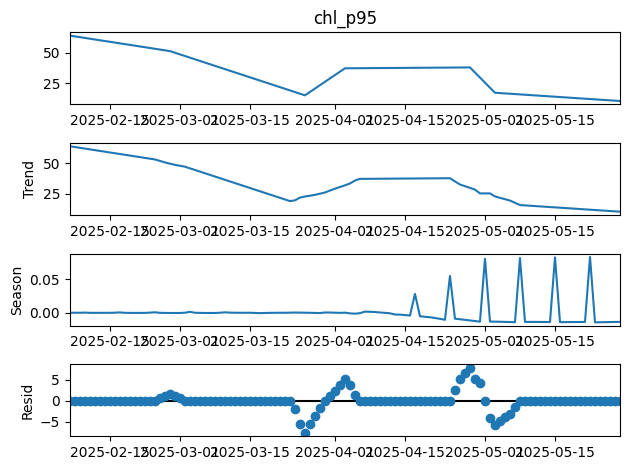

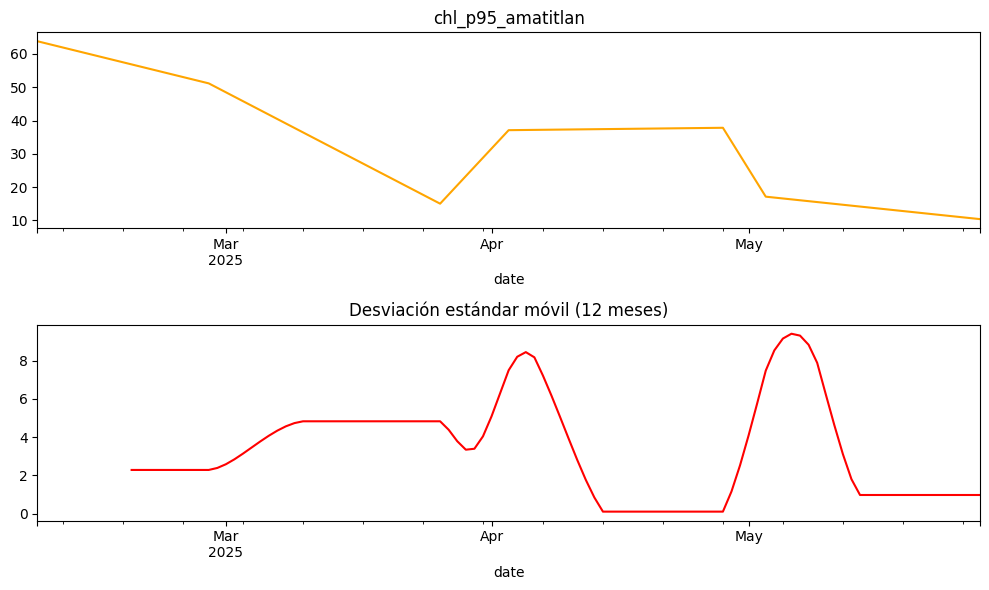

In [78]:
from statsmodels.tsa.seasonal import STL

res = STL(chl_p95_amatitlan.dropna(), period=7, robust=True).fit()
res.plot()
plt.show()


desvMovil = chl_p95_amatitlan.rolling(window=12).std()

fig, ax = plt.subplots(2, 1, figsize=(10,6))
chl_p95_amatitlan.plot(ax=ax[0], color="orange", title="chl_p95_amatitlan")
desvMovil.plot(ax=ax[1], color="red", title="Desviación estándar móvil (12 meses)")
plt.tight_layout()
plt.show()

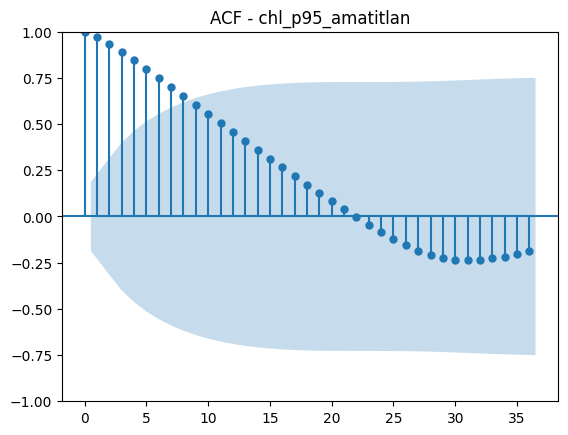

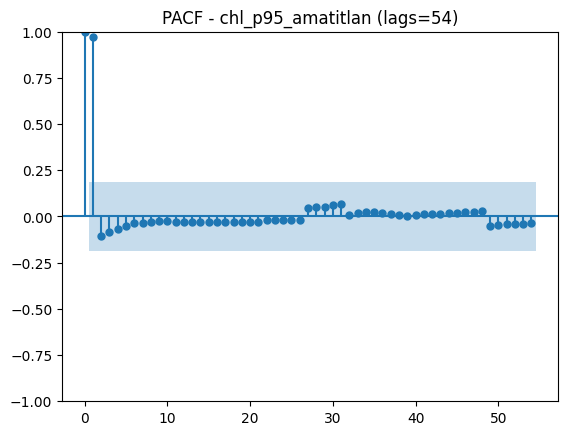

ADF: estadístico=-1.777, p-valor=0.392


In [80]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# ACF y PACF
plot_acf(chl_p95_amatitlan.dropna(), lags=36)
plt.title("ACF - chl_p95_amatitlan")
plt.show()

# Calcular lags máximo permitido para PACF
max_lags = int(len(chl_p95_amatitlan.dropna()) // 2) - 1
plot_pacf(chl_p95_amatitlan.dropna(), lags=max_lags, method="ywm")
plt.title(f"PACF - chl_p95_amatitlan (lags={max_lags})")
plt.show()

# Prueba ADF
stat, pval, lags, nobs, _, _ = adfuller(chl_p95_amatitlan.dropna(), autolag="AIC")
print(f"ADF: estadístico={stat:.3f}, p-valor={pval:.3f}")


In [81]:
# Verifica el mejor modelo con autoarima
from pmdarima import auto_arima

modelo_auto = auto_arima(chl_p95_amatitlan.dropna(),
     seasonal=True, 
     stepwise=True,
     trace=True)
print(modelo_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=242.569, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=369.687, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=238.153, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=297.342, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=242.569, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=369.687, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=238.153, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=297.342, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=382.596, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=239.340, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=239.482, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=382.596, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=239.340, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=239.482, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=239.5

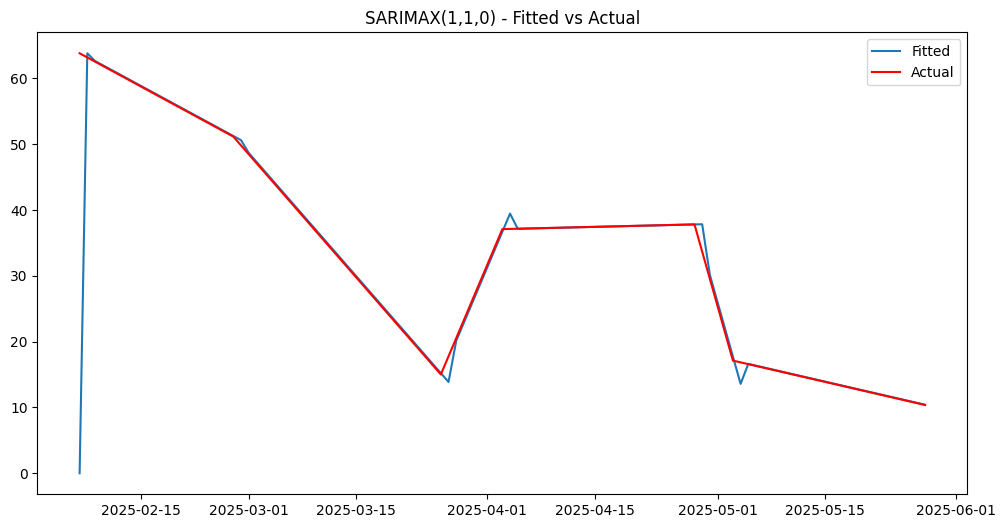

In [84]:
# El mejor modelo fue SARIMAX(1,1,0) sin estacionalidad. Realiza el modelo y grafica.

from statsmodels.tsa.statespace.sarimax import SARIMAX

best_model = SARIMAX(chl_p95_amatitlan.dropna(), order=(1, 1, 0), seasonal_order=(0, 0, 0, 0))
results_amatitlan = best_model.fit()
plt.show()

# Graficar serie contra valores del modelo
plt.figure(figsize=(12, 6))
plt.plot(results_amatitlan.fittedvalues)
plt.plot(chl_p95_amatitlan.dropna(), color='red')
plt.title('SARIMAX(1,1,0) - Fitted vs Actual')
plt.legend(['Fitted', 'Actual'])
plt.show()

## Construccion del modelo hibrido

In [3]:
# === Preprocesamiento de tu CSV ===
import pandas as pd

# Cargar archivo
df_raw = pd.read_csv("serie_inicio_fin_mes.csv")

# Parsear fechas y limpiar nulos
df_raw['date'] = pd.to_datetime(df_raw['date'], errors='coerce')
df_raw = df_raw.dropna(subset=['date'])

# Elegimos chl_median como índice principal
# (puedes cambiar a 'chl_p95' si quieres probar)
df_raw['cyano_index'] = df_raw['chl_median']

# Separar por lago
df_atitlan = df_raw[df_raw['lake'].str.contains("Atit", case=False)].copy()
df_amatitlan = df_raw[df_raw['lake'].str.contains("Amat", case=False)].copy()

# Mostrar tamaños y primeras filas
print("Atitlán:", df_atitlan.shape)
print("Amatitlán:", df_amatitlan.shape)
display(df_atitlan.head())
display(df_amatitlan.head())


Atitlán: (22, 13)
Amatitlán: (11, 13)


,lake,date,water_px,valid_px,coverage_pct_water,chl_mean,chl_median,chl_p95,ndvi_mean,ndwi_mean,tif_path,error,cyano_index
0,Amatitlan,2025-02-07,39401.0,39401.0,1.0,26.963100,20.768581,63.828270,-1.518291,2.041242,tiffs_mes\Amatitlan\Amatitlan_2025-02-07.tif,NaN,20.768581
1,Amatitlan,2025-02-27,53187.0,53187.0,1.0,15.771939,6.095391,51.166000,0.007404,0.155648,tiffs_mes\Amatitlan\Amatitlan_2025-02-27.tif,NaN,6.095391
2,Amatitlan,2025-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[400] NoDataAvailable: There is no data availa...,NaN
3,Amatitlan,2025-03-26,37480.0,37480.0,1.0,8.456269,7.469249,15.018612,0.009998,0.163318,tiffs_mes\Amatitlan\Amatitlan_2025-03-26.tif,NaN,7.469249
4,Amatitlan,2025-04-03,50712.0,50712.0,1.0,9.667562,5.114092,37.105206,-0.106983,0.255355,tiffs_mes\Amatitlan\Amatitlan_2025-04-03.tif,NaN,5.114092


,lake,date,water_px,valid_px,coverage_pct_water,chl_mean,chl_median,chl_p95,ndvi_mean,ndwi_mean,tif_path,error,cyano_index
0,Amatitlan,2025-02-07,39401.0,39401.0,1.0,26.963100,20.768581,63.828270,-1.518291,2.041242,tiffs_mes\Amatitlan\Amatitlan_2025-02-07.tif,NaN,20.768581
1,Amatitlan,2025-02-27,53187.0,53187.0,1.0,15.771939,6.095391,51.166000,0.007404,0.155648,tiffs_mes\Amatitlan\Amatitlan_2025-02-27.tif,NaN,6.095391
2,Amatitlan,2025-03-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[400] NoDataAvailable: There is no data availa...,NaN
3,Amatitlan,2025-03-26,37480.0,37480.0,1.0,8.456269,7.469249,15.018612,0.009998,0.163318,tiffs_mes\Amatitlan\Amatitlan_2025-03-26.tif,NaN,7.469249
4,Amatitlan,2025-04-03,50712.0,50712.0,1.0,9.667562,5.114092,37.105206,-0.106983,0.255355,tiffs_mes\Amatitlan\Amatitlan_2025-04-03.tif,NaN,5.114092


## Modelo de clasificacion + Serie de tiempo

In [ ]:
import numpy as np
import pandas as pd
import json

try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
except Exception:
    SARIMAX = None

try:
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import classification_report, roc_auc_score
    from sklearn.model_selection import TimeSeriesSplit
except Exception:
    LogisticRegression = None

def _coerce_datetime(df, date_col='date'):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)
    df = df.dropna(subset=[date_col, 'cyano_index'])
    return df

def fit_ts_forecast(df, horizon=3, date_col='date', y_col='cyano_index', exog_cols=None):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.dropna(subset=[date_col, y_col]).sort_values(date_col)

    agg = {y_col: 'median'}
    if exog_cols:
        for c in exog_cols:
            if c in df.columns:
                agg[c] = 'median'

    df_m = (df
            .set_index(date_col)
            .groupby(pd.Grouper(freq='MS'))
            .agg(agg)
            .dropna(how='all'))

    df_m[y_col] = pd.to_numeric(df_m[y_col], errors='coerce')
    df_m[y_col] = df_m[y_col].interpolate(limit_direction='both')

    if exog_cols:
        for c in exog_cols:
            if c in df_m.columns:
                df_m[c] = pd.to_numeric(df_m[c], errors='coerce')
                df_m[c] = df_m[c].interpolate(limit_direction='both')

    df_m = df_m.asfreq('MS')

    if SARIMAX is None:
        last = float(df_m[y_col].iloc[-1])
        fut_index = pd.date_range(df_m.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq='MS')
        return pd.DataFrame({date_col: fut_index, y_col: [last]*horizon})

    try:
        order = (1, 0, 1)
        seasonal_order = (0, 0, 0, 0)
        ex = df_m[exog_cols] if exog_cols else None
        model = SARIMAX(df_m[y_col], order=order, seasonal_order=seasonal_order,
                        exog=ex, enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)

        fut_index = pd.date_range(df_m.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq='MS')
        fut_exog = None
        if exog_cols:
            last_row = df_m[exog_cols].iloc[[-1]].values
            fut_exog = np.repeat(last_row, horizon, axis=0)

        fc = res.get_forecast(steps=horizon, exog=fut_exog)
        mean = fc.predicted_mean
        out = pd.DataFrame({date_col: fut_index, y_col: mean.values})
        return out
    except Exception:
        last = float(df_m[y_col].iloc[-1])
        fut_index = pd.date_range(df_m.index[-1] + pd.offsets.MonthBegin(1), periods=horizon, freq='MS')
        return pd.DataFrame({date_col: fut_index, y_col: [last]*horizon})


def train_classifier(df, date_col='date', y_col='cyano_index', exog_cols=None, threshold=0.7):
    import numpy as np
    df = df.copy()
    if 'label' not in df.columns:
        df['label'] = (df[y_col] >= threshold).astype(int)

    features = []
    if exog_cols:
        features += exog_cols
    features += [y_col]

    X = df[features].astype(float).values
    y = df['label'].astype(int).values
    uniq = np.unique(y)

    if len(uniq) < 2:
        alt_thr = float(np.nanpercentile(df[y_col].values, 70))
        y_alt = (df[y_col].values >= alt_thr).astype(int)
        if len(np.unique(y_alt)) >= 2:
            y = y_alt
        else:
            class SmoothScaler:
                def __init__(self, col_idx=-1, eps=1e-9):
                    self.col_idx = col_idx
                    cx = X[:, self.col_idx]
                    self.mn = float(np.nanmin(cx))
                    self.mx = float(np.nanmax(cx))
                    if not np.isfinite(self.mn): self.mn = 0.0
                    if not np.isfinite(self.mx): self.mx = 1.0
                    if abs(self.mx - self.mn) < eps:
                        self.mx = self.mn + 1.0
                def predict_proba(self, X_):
                    cx = X_[:, self.col_idx]
                    p = (cx - self.mn) / (self.mx - self.mn)
                    p = np.clip(p, 0.0, 1.0)
                    return np.vstack([1 - p, p]).T
                def predict(self, X_):
                    return (self.predict_proba(X_)[:, 1] >= 0.5).astype(int)
            clf = SmoothScaler(col_idx=-1)
            metrics = {'note': 'Fallback por clase única: clasificador suave basado en min-max de cyano_index.'}
            return clf, features, metrics

    try:
        from sklearn.linear_model import LogisticRegression
        from sklearn.metrics import classification_report, roc_auc_score
        from sklearn.model_selection import TimeSeriesSplit
        clf = LogisticRegression(max_iter=200)
        try:
            tscv = TimeSeriesSplit(n_splits=min(4, max(2, len(df)//6)))
            aucs = []
            for tr, te in tscv.split(X):
                clf.fit(X[tr], y[tr])
                proba = clf.predict_proba(X[te])[:, 1]
                aucs.append(roc_auc_score(y[te], proba))
            mean_auc = float(np.mean(aucs)) if aucs else None
        except Exception:
            mean_auc = None
        clf.fit(X, y)
        preds = clf.predict(X)
        try:
            report = classification_report(y, preds, output_dict=True)
        except Exception:
            report = None
        metrics = {'cv_auc_mean': mean_auc, 'train_report': report}
        return clf, features, metrics
    except Exception:
        class SimpleThresh:
            def __init__(self, thr): self.thr = thr
            def predict_proba(self, X_):
                p = (X_[:, -1] >= self.thr).astype(float)
                return np.vstack([1 - p, p]).T
            def predict(self, X_):
                return (X_[:, -1] >= self.thr).astype(int)
        clf = SimpleThresh(threshold)
        metrics = {'note': 'Clasificador por umbral (sin scikit-learn).'}
        return clf, features, metrics


def hybrid_predict(df_hist, horizon=3, exog_cols=None, threshold=0.7, lake_name='(lake)'):
    df_hist = _coerce_datetime(df_hist)
    fc = fit_ts_forecast(df_hist, horizon=horizon, exog_cols=exog_cols)
    clf, feat_cols, metrics = train_classifier(df_hist, exog_cols=exog_cols, threshold=threshold)

    fut_df = fc.copy()
    if exog_cols:
        last_vals = df_hist[exog_cols].iloc[[-1]].reset_index(drop=True)
        for c in exog_cols:
            fut_df[c] = last_vals.at[0, c]

    Xf = fut_df[feat_cols].astype(float).values
    try:
        proba = clf.predict_proba(Xf)[:, 1]
        pred_label = (proba >= 0.5).astype(int)
    except Exception:
        pred_label = (fut_df['cyano_index'] >= threshold).astype(int)
        proba = pred_label.astype(float)

    out = fut_df.copy()
    out['lake'] = lake_name
    out['pred_cyano_index'] = out['cyano_index']
    out['pred_prob_contaminated'] = proba
    out['pred_label'] = pred_label
    out = out.drop(columns=['cyano_index'])
    return out, metrics

if 'df_atitlan' not in globals() or 'df_amatitlan' not in globals():
    raise RuntimeError("Define primero df_atitlan y df_amatitlan con las columnas requeridas.")

df_atitlan = _coerce_datetime(df_atitlan)
df_amatitlan = _coerce_datetime(df_amatitlan)

candidate_exog = [c for c in ['ndvi', 'ndwi', 'temp', 'precip'] if c in df_atitlan.columns and c in df_amatitlan.columns]
exog_cols = candidate_exog if candidate_exog else None

thr_at = float(np.nanpercentile(df_atitlan['cyano_index'], 70))
thr_am = float(np.nanpercentile(df_amatitlan['cyano_index'], 70))

HORIZON = 3

pred_atitlan, metrics_at = hybrid_predict(
    df_atitlan, horizon=HORIZON, exog_cols=exog_cols, threshold=thr_at, lake_name='Atitlán'
)
pred_amatitlan, metrics_am = hybrid_predict(
    df_amatitlan, horizon=HORIZON, exog_cols=exog_cols, threshold=thr_am, lake_name='Amatitlán'
)

pred_all = pd.concat([pred_atitlan, pred_amatitlan], ignore_index=True)

print("=== Predicciones híbridas (primeras filas) ===")
display(pred_all.head())

print("\n=== Métricas Atitlán ===")
print(json.dumps(metrics_at, indent=2, default=str))

print("\n=== Métricas Amatitlán ===")
print(json.dumps(metrics_am, indent=2, default=str))


=== Predicciones híbridas (primeras filas) ===


,date,lake,pred_cyano_index,pred_prob_contaminated,pred_label
0,2025-09-01,Atitlán,4.141373,0.119467,0
1,2025-10-01,Atitlán,4.040041,0.102661,0
2,2025-11-01,Atitlán,3.941188,0.088319,0
3,2025-06-01,Amatitlán,3.546319,0.017927,0
4,2025-07-01,Amatitlán,2.790528,0.008432,0



=== Métricas Atitlán ===
{
  "cv_auc_mean": null,
  "train_report": {
    "0": {
      "precision": 0.8571428571428571,
      "recall": 1.0,
      "f1-score": 0.9230769230769231,
      "support": 12.0
    },
    "1": {
      "precision": 1.0,
      "recall": 0.6666666666666666,
      "f1-score": 0.8,
      "support": 6.0
    },
    "accuracy": 0.8888888888888888,
    "macro avg": {
      "precision": 0.9285714285714286,
      "recall": 0.8333333333333333,
      "f1-score": 0.8615384615384616,
      "support": 18.0
    },
    "weighted avg": {
      "precision": 0.9047619047619047,
      "recall": 0.8888888888888888,
      "f1-score": 0.882051282051282,
      "support": 18.0
    }
  }
}

=== Métricas Amatitlán ===
{
  "cv_auc_mean": null,
  "train_report": {
    "0": {
      "precision": 0.8333333333333334,
      "recall": 1.0,
      "f1-score": 0.9090909090909091,
      "support": 5.0
    },
    "1": {
      "precision": 1.0,
      "recall": 0.5,
      "f1-score": 0.6666666666666666,


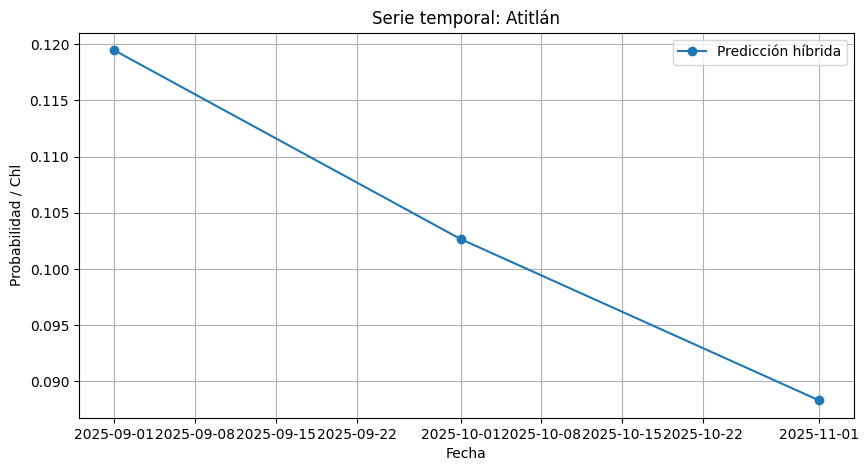

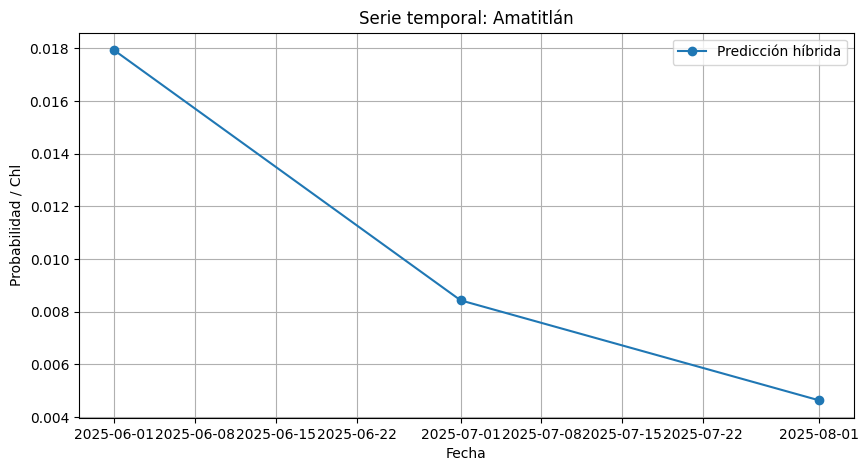

In [10]:
import matplotlib.pyplot as plt

def plot_real_vs_pred(df, lake, var='pred_prob_contaminated'):
    df_lake = df[df['lake'] == lake].sort_values('date')

    plt.figure(figsize=(10,5))
    plt.plot(df_lake['date'], df_lake[var], marker='o', label='Predicción híbrida')

    # Opcional: si tienes los valores originales (reales) de chl_median/p95
    if 'chl_median' in df_lake.columns:
        plt.plot(df_lake['date'], df_lake['chl_median'], marker='x', linestyle='--', label='Chl_median (real)')
    if 'chl_p95' in df_lake.columns:
        plt.plot(df_lake['date'], df_lake['chl_p95'], marker='s', linestyle=':', label='Chl_p95 (real)')

    plt.title(f"Serie temporal: {lake}")
    plt.xlabel("Fecha")
    plt.ylabel("Probabilidad / Chl")
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejemplo con cada lago
for lake in pred_all['lake'].unique():
    plot_real_vs_pred(pred_all, lake)


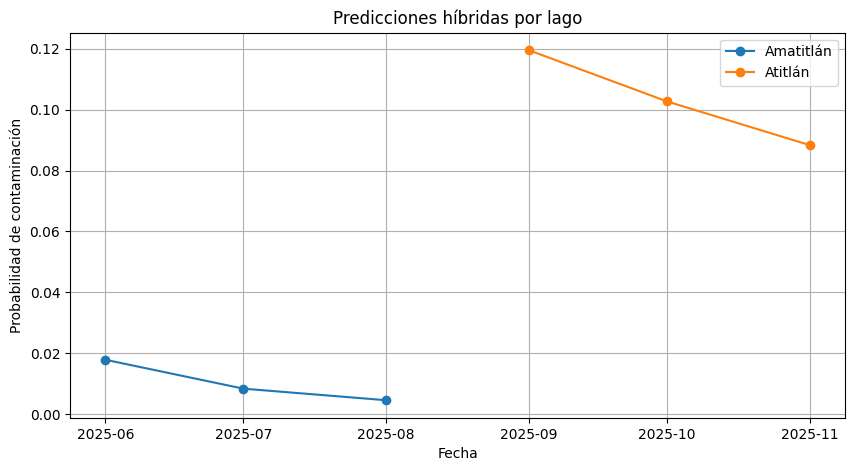

In [12]:
plt.figure(figsize=(10,5))
for lake, sub in pred_all.groupby('lake'):
    plt.plot(sub['date'], sub['pred_prob_contaminated'], marker='o', label=lake)

plt.title("Predicciones híbridas por lago")
plt.xlabel("Fecha")
plt.ylabel("Probabilidad de contaminación")
plt.legend()
plt.grid(True)
plt.show()



En las graficas del modelo hibrido se puede ver como cambia la probabilidad de contaminación en cada lago con el tiempo. En Atitlán la probabilidad empieza mas alta en septiembre y va bajando hasta noviembre, aunque sigue siendo mayor que en Amatitlán. En este último, los valores son mucho mas bajos y también muestran una pequeña reducción entre junio y agosto, que podemos atribuir a que hay menos valores que en atitlan. Al comparar los dos, se nota que los dos lagos tienden a mejorar, pero Atitlán todavía tiene un riesgo más alto que Amatitlán en el periodo analizado. 

Esto nos pone a pensar si el modelo esta correcto por que se sabe que amatitlan tiene un riesgo mas elevado de contaminacion en comparacion a atitlan

## Mapa de la predicción

In [ ]:
import folium
from folium.plugins import HeatMap
import branca.colormap as cm

if 'pred_all' not in globals():
    raise RuntimeError("Falta 'pred_all'. Ejecuta antes el bloque del modelo híbrido.")

dfp = pred_all.copy()
dfp['date'] = pd.to_datetime(dfp['date'], errors='coerce')
dfp = dfp.dropna(subset=['date', 'pred_prob_contaminated', 'lake']).reset_index(drop=True)
dfp['pred_prob_contaminated'] = dfp['pred_prob_contaminated'].clip(0, 1)

print("=== Probabilidades reales (promedio por lago/fecha) ===")
print(dfp.groupby(['lake','date'])['pred_prob_contaminated'].mean())

# ---------- PARÁMETROS DE VISUALIZACIÓN ----------
# Se pueden modificar para poder personalizar la visualización

EXAGGERATION = 25.0   # multiplica la prob real antes de recortar (sube si aún no ves)
GAMMA = 0.55          # <1 aclara valores bajos (0.55–0.7 recomendados)
FLOOR = 0.18          # piso visual mínimo para que siempre se vea algo (0–0.3)
MIN_OPACITY = 0.6     # opacidad base
BASE_RADIUS = 10      # radio base
RADIUS_BONUS = 10     # incremento según p_vis
GRID_N = 26           # densidad de rejilla (más puntos = más visible)
SHOW_HEATMAP = True   # activa heatmap adicional

bbox_atitlan   = dict(west=-91.326256, east=-91.071510, south=14.594800, north=14.750979)
bbox_amatitlan = dict(west=-90.638065, east=-90.512924, south=14.412347, north=14.493799)
bbox_by_lake = {'Atitlán': bbox_atitlan, 'Amatitlán': bbox_amatitlan}

def bbox_to_bounds(b):
    return [[b['south'], b['west']], [b['north'], b['east']]]

def bbox_center(b):
    return ( (b['south']+b['north'])/2.0, (b['west']+b['east'])/2.0 )

p_real = dfp['pred_prob_contaminated'].values.astype(float)
p_scaled = np.clip(p_real * EXAGGERATION, 0.0, 1.0)
p_gamma = np.power(p_scaled, GAMMA)
p_vis = np.maximum(FLOOR, p_gamma)
dfp['p_vis'] = p_vis

print("\n=== Rango p_vis (ya escalado) ===")
print(dfp['p_vis'].agg(['min','max','mean']).to_dict())

cmap = cm.LinearColormap(
    colors=['#2c7fb8', '#7fcdbb', '#ffffbf', '#fdae61', '#d7191c'],
    vmin=0.0, vmax=1.0
)

center_lat = (bbox_atitlan['north'] + bbox_amatitlan['south'])/2
center_lon = (bbox_atitlan['east'] + bbox_amatitlan['west'])/2
m = folium.Map(location=[center_lat, center_lon], zoom_start=9, tiles='OpenStreetMap')

horizon_dates = sorted(dfp['date'].unique())
all_bounds = []

for d in horizon_dates:
    df_d = dfp[dfp['date'] == d]
    fg_date = folium.FeatureGroup(name=f"Pronóstico {pd.to_datetime(d).strftime('%Y-%m')}", show=False)

    for lake, df_lake in df_d.groupby('lake'):
        bbox = bbox_by_lake.get(lake)
        if bbox is None:
            continue
        prob_real_mean = float(df_lake['pred_prob_contaminated'].mean())
        p_vis_mean = float(df_lake['p_vis'].mean())

        lons = np.linspace(bbox['west'], bbox['east'], GRID_N)
        lats = np.linspace(bbox['south'], bbox['north'], GRID_N)
        xs, ys = np.meshgrid(lons, lats)
        sub = pd.DataFrame({
            'lake': lake,
            'date': pd.to_datetime(d),
            'lon': xs.ravel(),
            'lat': ys.ravel(),
            'prob_real': prob_real_mean,
            'p_vis': p_vis_mean
        })

        fg_lake = folium.FeatureGroup(name=f"{lake} — {pd.to_datetime(d).strftime('%Y-%m')}", show=False)

        for _, r in sub.iterrows():
            pv = float(r['p_vis'])
            color = cmap(pv)
            folium.CircleMarker(
                location=[float(r['lat']), float(r['lon'])],
                radius=BASE_RADIUS + RADIUS_BONUS*pv,
                weight=0.8,
                color=color,
                fill=True,
                fill_color=color,
                fill_opacity=MIN_OPACITY + (1.0 - MIN_OPACITY)*pv,
                tooltip=f"{lake} | {pd.to_datetime(d).strftime('%Y-%m-%d')} | prob_real≈{float(r['prob_real']):.3f} | p_vis={pv:.2f}"
            ).add_to(fg_lake)

        if SHOW_HEATMAP:
            HeatMap(sub[['lat','lon','p_vis']].values.tolist(),
                    radius=22, blur=28, min_opacity=0.35,
                    name=f"Heatmap {lake} {pd.to_datetime(d).strftime('%Y-%m')}"
                   ).add_to(fg_lake)

        folium.Rectangle(bounds=bbox_to_bounds(bbox), color="#333", weight=1, fill=False, dash_array="5,5").add_to(fg_lake)
        clat, clon = bbox_center(bbox)
        folium.Marker(
            location=[clat, clon],
            icon=folium.DivIcon(html=f"<div style='font-size:12px; font-weight:bold; color:#111; background:white; padding:2px 4px; border-radius:4px;'>"
                                     f"{lake}: {prob_real_mean:.3f}</div>")
        ).add_to(fg_lake)

        fg_lake.add_to(fg_date)
        all_bounds.append(bbox_to_bounds(bbox))

    fg_date.add_to(m)

for child in reversed(list(m._children.values())):
    if isinstance(child, folium.map.FeatureGroup) and "Pronóstico" in child.layer_name:
        child.show = True
        break

folium.LayerControl(collapsed=False).add_to(m)
cmap.caption = "Intensidad visual p_vis (escalada)"
m.add_child(cmap)

if all_bounds:
    south = min(b[0][0] for b in all_bounds)
    west  = min(b[0][1] for b in all_bounds)
    north = max(b[1][0] for b in all_bounds)
    east  = max(b[1][1] for b in all_bounds)
    m.fit_bounds([[south, west], [north, east]])

MAP_PATH = "mapa_predicciones_exaggerated.html"
m.save(MAP_PATH)
print(f"\nMapa guardado como {MAP_PATH}")


=== Probabilidades reales (promedio por lago/fecha) ===
lake       date      
Amatitlán  2025-06-01    0.017927
           2025-07-01    0.008432
           2025-08-01    0.004640
Atitlán    2025-09-01    0.119467
           2025-10-01    0.102661
           2025-11-01    0.088319
Name: pred_prob_contaminated, dtype: float64

=== Rango p_vis (ya escalado) ===
{'min': 0.3058114247569547, 'max': 1.0, 'mean': 0.7289465641996572}

Mapa guardado como mapa_predicciones_exaggerated.html


En este caso, el mapa se creo con exito, pero el valor de contaminacion es tan bajo que no se logra notar en las capas que se estableció en Folium, a pesar de que se escalaron agresivamente los datos para poder logar ver algo.

Se considero el uso de valores mucho mas altos para intentar pero creimos que se perderia el sentido del mapa ya que estariamos forzando los colores solo para ver algo en el mapa. Puede que el modelo tuviera algunos errores o que realmente el crecimiento de la contaminacion sera bastante baja en los proximos meses. 

Podriamos pensar en predecir a muchos mas meses o hasta años para poder lograr ver algun cambio significativo, especialmente en el lago de Amatitlan que tiene mas tendencia a la contaminación.

## Analisis de los modelos

Para este modelo hibrido tenemos dos clases de la serie de tiempo, 0 siendo no contaminado y 1 contaminado. Podemos ver que en terminos de clasificación el modelo alcanza valores bastante altos en la predicción de no contaminados, pero tiene algunos problemas al predecir la contaminacion de los dos lagos. A pesar de esto vemos que la accuracy es bastante alta siendo 0.88 en atitlan y 0.85 en amatitlan. 

Consideramos estos valores relativamente buenos ya que se hizo el filtrado correspondiente y el modelo no tuvo mucho problema para procesar los datos, aunque si se quiere conseguir datos mas altos, podriamos modificar ciertos datos o verificar pesos que pueden mejorar el valor.

Si podriamos considerar tomar muchos mas datos que los que utilizamos. Esto mejoraria mucho mas el nivel de la prediccion o daria resultados mas acercados a la realidad. Los datos que estamos usando fueron tomados solo desde febrero de este año ya algunas fechas no tenian resultados validos para este estudio.

Aunque tuvimos todas estas limitaciones, el modelo hibrido tuvo mejor desempeño que el modelo de series de tiempo que se hizo al inicio. Esto no es tanto por el valor de acierto que se ve en los modelos, si no que da datos que pueden ser mas reales o que sí se podrian tomar en cuenta, más que nada por el proceso mas detallado que lleva el modelo hibrido.